<a href="https://colab.research.google.com/github/Fatikha-Imamagzam/Fingerprint_analisys/blob/main/FP_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Oct 15 21:44:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 45.2 MB/s 


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



from sklearn import metrics
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report, accuracy_score 
from imutils import paths
import os
from glob import glob
import cv2
import numpy as np
import pathlib
import joblib  

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import DataFrame  
import random
from sklearn.utils import shuffle
from sklearn.datasets._samples_generator import make_blobs
import tensorflow as tf
from tensorflow.keras import layers
import imgaug.augmenters as iaa

#cnn------------------------------
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from keras.metrics import categorical_crossentropy, binary_crossentropy 
# optimization method 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from livelossplot.inputs.keras import PlotLossesCallback
from keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import ModelCheckpoint, EarlyStopping 

end = ["\033[0;30;1m","\033[1;31;1m","\033[1;32;1m", "\033[1;33;1m", "\033[1;34;1m", "\033[1;35;1m"] 

# Fonksyonlar

In [ ]:
def getRawDataSet(dataset_cat_path):    
    print(f"{end[1]}Data Alınıyor....")
    #cat_type = dataset_cat_path[0].split("/")[-1].split("\\")[0]
    cat_type = dataset_cat_path[0].split("/")[-2]
    cat = []
    for image in dataset_cat_path:
        img  = cv2.imread(image)
        img = cv2.resize(img, (227,227), interpolation = cv2.INTER_AREA)
        cat.append(img) 
    print(f"{end[2]}Hazırlandı!{end[0]}")
    print(f"{end[4]}Toplam '{cat_type}' Resimler: {len(cat)}  {end[0]}\n\n")
    return cat

def augmentDatasetCon(dataset_cat, max_len):
    print(f"{end[1]}Resim Çoğatılıyor....")
    n_cat = dataset_cat
    augmentation= iaa.Sequential([
    iaa.Rot90(1),
    #1 Flip
    iaa.Fliplr(1),
    iaa.Flipud(1),
    ])  
    
    augmented_data = augmentation(images=dataset_cat)
    for image in augmented_data:
        if len(n_cat)>=max_len:
            break
        else:
            n_cat.append(image)  

    print(f"{end[2]}Çoğatma Tamamlandı!{end[0]}")
    print(f"{end[4]}Yeni Boyut: {len(n_cat)} resimler {end[0]}\n\n")
    return n_cat


def Alexnet(INPUT_SHAPE = (227,227,3), N_CLASSES=2, LR=0.1):
    # Initialize the model
    # Modeli başlat
    model = Sequential()

    # layer 1: convolutional layer + max-pooling layer
    # katman 1: evrişimli katman + maksimum havuzlama katmanı
    model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', 
                   activation='relu', input_shape = INPUT_SHAPE ))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

    # layer 2: convolutional layer + max-pooling layer 
    # katman 2: evrişimli katman + maksimum havuzlama katmanı
    model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', 
                   activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

    # layers 3-5: three convolutional layers + 1 max-pooling layer
    # katman 3-5: üç evrişim katmanı + 1 maksimum havuzlama katmanı
    model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
    model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', 
                   activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

    # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
    # katman 6 - 8: iki tam bağlantılı gizli katman ve bir tam bağlantılı çıktı katmanı
    model.add(Flatten())
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation = 'softmax'))

    # compile the model with a loss function, a metric and and optimizqation method
    # modeli bir kayıp fonksiyonu, bir metrik ve optimizasyon yöntemiyle derleyin
    opt = SGD(learning_rate = LR)
    model.compile(loss = categorical_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

    return model

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, model_path):
    # Data generator
    # Veri oluşturucu
    datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)
    
    # iteration on the training set
    # iteration on the training set
    it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
    
    # Plotting during Training  
    # Eğitim Sırasında Çizim
    plot_loss_1 = PlotLossesCallback() 

    # path to save the checkpoint 
    # kontrol noktasını kaydetme yolu
    tl_checkpoint_1 = ModelCheckpoint(filepath= model_path,
                                      save_best_only=True,
                                      verbose=1)

    # EarlyStopping
    # İzlenen bir metrik iyileştirmeyi bıraktığında eğitimi durdurun
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=150,
                               restore_best_weights=True,
                               mode='min')
    
    steps = X_train.shape[0]//batch_size
    # Fitting the model
    # Modelin takılması
    history = model.fit(it_train, epochs = epochs, steps_per_epoch = steps, 
                                validation_data = (X_test, y_test), verbose = "auto", 
                                 callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                                 )
    # Evaluating the model
    # Modelin değerlendirilmesi
    _, acc = model.evaluate(X_test, y_test, verbose = 1)
    print('%.3f' % (acc * 100.0))

    return history, acc

def preprocess_data(X, y):
    # convert X from list to array
    # X'i listeden diziye dönüştür
    X = np.array(X)

    # convert integer values of X into floats
    # X'in tamsayı değerlerini kayan noktalara dönüştürün
    X = X.astype(np.float32)

    # normalization
    # normalleştirme
    X = X/255.0

    # one-hot encoding the labels 
    # Tahminde daha iyi bir iş çıkarmak için ML algoritmalarına dönüştürülen kategorik değişkenler
    y = to_categorical(np.array(y))

    return X, y

# Data Hazırlama

In [ ]:
model_path = "/content/drive/MyDrive/SON_models_Finger"
test_path = "/content/drive/MyDrive/Data_Files_Finger/gender/testing"

In [ ]:
%%time
#gender
female_path =   glob("/content/drive/MyDrive/Data_Files_Finger/gender/training/female/*")
male_path =   glob("/content/drive/MyDrive/Data_Files_Finger/gender/training/male/*")
male_images = getRawDataSet(male_path)
female_images = getRawDataSet(female_path)


Data Alınıyor....
Hazırlandı!
Toplam 'male' Resimler: 627  


Data Alınıyor....
Hazırlandı!
Toplam 'female' Resimler: 1283  


CPU times: user 13.8 s, sys: 1.08 s, total: 14.9 s
Wall time: 7min 22s


In [ ]:
max_len = max([len(female_images), len(male_images)])
max_len = max_len*2
max_len

2566

In [ ]:
female_images = augmentDatasetCon(female_images, max_len)  
male_images = augmentDatasetCon(male_images, max_len)  

Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 2566 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 1254 resimler 




In [ ]:
%%time
#age
path_0_30 =   glob("/content/drive/MyDrive/Data_Files_Finger/age/training/0_30/*") 
path_31_40 =   glob("/content/drive/MyDrive/Data_Files_Finger/age/training/31_40/*")
path_41_50 =   glob("/content/drive/MyDrive/Data_Files_Finger/age/training/41_50/*")
path_51_above =   glob("/content/drive/MyDrive/Data_Files_Finger/age/training/51_above/*")
images_0_30 = getRawDataSet(path_0_30)
images_31_40 = getRawDataSet(path_31_40)
images_41_50 = getRawDataSet(path_41_50)
images_51_above = getRawDataSet(path_51_above)

Data Alınıyor....
Hazırlandı!
Toplam '0_30' Resimler: 448  


Data Alınıyor....
Hazırlandı!
Toplam '31_40' Resimler: 429  


Data Alınıyor....
Hazırlandı!
Toplam '41_50' Resimler: 407  


Data Alınıyor....
Hazırlandı!
Toplam '51_above' Resimler: 476  


CPU times: user 15.4 s, sys: 1.43 s, total: 16.9 s
Wall time: 21min 18s


In [ ]:
max_len = max([len(images_0_30), len(images_31_40), len(images_41_50), len(images_51_above)])
max_len = max_len*2
max_len

952

In [ ]:
images_0_30 = augmentDatasetCon(images_0_30, max_len) 

images_31_40 = augmentDatasetCon(images_31_40, max_len) 

images_41_50 = augmentDatasetCon(images_41_50, max_len)

images_51_above = augmentDatasetCon(images_51_above, max_len) 

Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 896 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 858 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 814 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 952 resimler 




In [ ]:
%%time
#race
african_american_path =   glob("/content/drive/MyDrive/Data_Files_Finger/race/training/african_american/*")
asian_path =   glob("/content/drive/MyDrive/Data_Files_Finger/race/training/asian/*")
white_path =   glob("/content/drive/MyDrive/Data_Files_Finger/race/training/white/*")
white_images = getRawDataSet(white_path)
asian_images = getRawDataSet(asian_path)
african_american_images = getRawDataSet(african_american_path)

Data Alınıyor....
Hazırlandı!
Toplam 'white' Resimler: 1325  


Data Alınıyor....
Hazırlandı!
Toplam 'asian' Resimler: 110  


Data Alınıyor....
Hazırlandı!
Toplam 'african_american' Resimler: 326  


CPU times: user 12.7 s, sys: 924 ms, total: 13.6 s
Wall time: 7min 17s


In [ ]:
max_len = max([len(white_images), len(asian_images), len(african_american_images)])
max_len = max_len*2
max_len

2650

In [ ]:
white_images = augmentDatasetCon(white_images, max_len) 

asian_images = augmentDatasetCon(asian_images, max_len) 

african_american_images = augmentDatasetCon(african_american_images, max_len)

Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 2650 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 220 resimler 


Resim Çoğatılıyor....
Çoğatma Tamamlandı!
Yeni Boyut: 652 resimler 




In [ ]:
classes = [["female", "male"],["0_30", "31_40", "41_50", "51_above"], ["white", "asian", "african-american"]]

# Birleştirme

In [ ]:
gender_images_dict = {
    'female': male_images,
    'male': female_images, 
    
}
gender_labels_dict = {
    'female': 0,
    'male': 1, 
}

In [ ]:
age_images_dict = { 
    "0_30":images_0_30,
    "31_40":images_31_40,
    "41_50":images_41_50,
    "51_above":images_51_above
}
age_labels_dict = {
    "0_30":0,
    "31_40":1,
    "41_50":2,
    "51_above":3
}

In [ ]:
race_images_dict = {  
    "white":white_images,
    "asian":asian_images,
    "african-american":african_american_images
}
race_labels_dict = {
    "white":0,
    "asian":1,
    "african-american":2
}

# Bu kısımından sonra AlexNet ile devam eder!

In [ ]:
%%time
print(f"{end[4]}Resim categori birleştiriliyor...")
gender_data, gender_labels= [], []
for gender_name, images in gender_images_dict.items():
    for image in images:  
        #print(image)
        #print(gender_name)
        gender_data.append(image)
        gender_labels.append(gender_labels_dict[gender_name])
        
(gender_Alex_X_train, gender_Alex_X_test, gender_Alex_Y_train, gender_Alex_Y_test ) = train_test_split(gender_data, gender_labels, test_size= 0.2, random_state=42)
print(f"{end[2]}Tamamlandı!\n{end[0]}")

Resim categori birleştiriliyor...
Tamamlandı!

CPU times: user 4.03 ms, sys: 100 µs, total: 4.13 ms
Wall time: 4.2 ms


In [ ]:
%%time
print(f"{end[4]}Resim categori birleştiriliyor...")
age_data, age_labels= [], []
for age_name, images in age_images_dict.items():
    for image in images:   
        age_data.append(image)
        age_labels.append(age_labels_dict[age_name])
        
(age_Alex_X_train, age_Alex_X_test, age_Alex_Y_train, age_Alex_Y_test ) = train_test_split(age_data, age_labels, test_size= 0.2, random_state=42)
print(f"{end[2]}Tamamlandı!\n{end[0]}")

Resim categori birleştiriliyor...
Tamamlandı!

CPU times: user 4.28 ms, sys: 2.12 ms, total: 6.4 ms
Wall time: 5.8 ms


In [ ]:
%%time
print(f"{end[4]}Resim categori birleştiriliyor...")
race_data, race_labels= [], []
for race_name, images in race_images_dict.items():
    for image in images:   
        race_data.append(image)
        race_labels.append(race_labels_dict[race_name])
        
(race_Alex_X_train, race_Alex_X_test, race_Alex_Y_train, race_Alex_Y_test ) = train_test_split(race_data, race_labels, test_size= 0.2, random_state=42)     
print(f"{end[2]}Tamamlandı!\n{end[0]}")

Resim categori birleştiriliyor...
Tamamlandı!

CPU times: user 3.65 ms, sys: 55 µs, total: 3.71 ms
Wall time: 3.48 ms


# SVM & KNN devam

In [ ]:
%%time
gender_data = np.array(gender_data,dtype=float)
gender_labels = np.array(gender_labels) 

le = LabelEncoder()
gender_labels = le.fit_transform(gender_labels)
myset = set(gender_labels)
#print(myset)
#print(gender_data)
dataset_size = gender_data.shape[0]
#print(dataset_size)
gender_data = gender_data.reshape(dataset_size,-1)

print(f"data.shape: {gender_data.shape}")
print(f"lables.shape: {gender_labels.shape}")
print(f"dataset_size: {dataset_size}")

(gender_X_train, gender_X_test, gender_Y_train, gender_Y_test ) = train_test_split(gender_data, gender_labels, test_size= 0.2, random_state=42)
print(f"{end[2]}Tamamlandı!\n{end[0]}")

NameError: ignored

In [ ]:
%%time
age_data = np.array(age_data,dtype=float)
age_labels = np.array(age_labels) 

le = LabelEncoder()
age_labels = le.fit_transform(age_labels)
myset = set(age_labels)
#print(myset)

#print(age_data)
dataset_size = age_data.shape[0]
#print(age_data.shape)

age_data = age_data.reshape(dataset_size,-1)

print(f"data.shape: {age_data.shape}")
print(f"lables.shape: {age_labels.shape}")
print(f"dataset_size: {dataset_size}")

(age_X_train, age_X_test, age_Y_train, age_Y_test ) = train_test_split(age_data, age_labels, test_size= 0.2, random_state=42)
print(f"{end[2]}Tamamlandı!\n{end[0]}")

In [ ]:
%%time
race_data = np.array(race_data,dtype=float)
race_labels = np.array(race_labels) 

le = LabelEncoder()
race_labels = le.fit_transform(race_labels)
myset = set(race_labels)
#print(myset)

#print(race_data)
dataset_size = race_data.shape[0]
#print(race_data.shape)

race_data = race_data.reshape(dataset_size,-1)

print(f"data.shape: {race_data.shape}")
print(f"lables.shape: {race_labels.shape}")
print(f"dataset_size: {dataset_size}")

(race_X_train, race_X_test, race_Y_train, race_Y_test ) = train_test_split(race_data, race_labels, test_size= 0.2, random_state=42)
print(f"{end[2]}Tamamlandı!\n{end[0]}")

**SVM & KNN için: Eğitme ve Değerlendirme-Test**


In [ ]:
def adjustKNN(X_train, X_test, Y_train, Y_test, classes, nn=6, nj=-1, p1=2): 
    model = KNeighborsClassifier(n_neighbors=nn, n_jobs=nj, metric='minkowski', p=p1)
    model.fit(X_train, Y_train)   
    
    
    
    print(classification_report(Y_test, model.predict(X_test), target_names=classes))
    print(f"Knn için Doğruluk: {'{:0.2f}'.format(accuracy_score(Y_test, model.predict(X_test) )*100)}%")
    return model


def adjustSVM(X_train, X_test, Y_train, Y_test, classes, nn=6, nj=-1, p1=2): 
    model = SVC()
    model.fit(X_train, Y_train) 
    
    print(classification_report(Y_test, model.predict(X_test), target_names=classes))
    print(f"SVM için Doğruluk: {'{:0.2f}'.format(accuracy_score(Y_test, model.predict(X_test) )*100)}%")
    return model
 

In [ ]:
%%time
clf_type = "Gender"
gender_KNN_model =  adjustKNN(gender_X_train, gender_X_test, gender_Y_train, gender_Y_test, classes[0], nn=5, nj=-1, p1=2)  

In [ ]:
%%time
clf_type = "Gender"
gender_SVM_model =  adjustSVM(gender_X_train, gender_X_test, gender_Y_train, gender_Y_test, classes[0], nn=5, nj=-1, p1=2)  

In [ ]:
%%time
clf_type = "Age"
age_KNN_model =  adjustKNN(age_X_train, age_X_test, age_Y_train, age_Y_test, classes[1], nn=5, nj=-1, p1=2) 

In [ ]:
%%time
clf_type = "Age"
age_SVM_model =  adjustSVM(age_X_train, age_X_test, age_Y_train, age_Y_test, classes[1], nn=5, nj=-1, p1=2) 

In [ ]:
%%time
clf_type = "Race"
race_KNN_model =  adjustKNN(race_X_train, race_X_test, race_Y_train, race_Y_test, classes[2], nn=5, nj=-1, p1=2) 

In [ ]:
%%time
clf_type = "Race"
race_SVM_model =  adjustSVM(race_X_train, race_X_test, race_Y_train, race_Y_test, classes[2], nn=5, nj=-1, p1=2) 

In [ ]:
# Save the models as pickle in a files
gender_save_path = "/content/drive/MyDrive/SON_models_Finger/KNNaugSgenderModel.pkl"
joblib.dump(gender_KNN_model, gender_save_path)
gender_save_path = "/content/drive/MyDrive/SON_models_Finger/SVMaugSgenderModel.pkl"
joblib.dump(gender_SVM_model, gender_save_path)

age_save_path = "/content/drive/MyDrive/SON_models_Finger/KNNaugSageModel.pkl"
joblib.dump(age_KNN_model, age_save_path)
age_save_path = "/content/drive/MyDrive/SON_models_Finger/SVMaugSageModel.pkl"
joblib.dump(age_SVM_model, age_save_path)

race_save_path = "/content/drive/MyDrive/SON_models_Finger/KNNaugSraceModel.pkl"
joblib.dump(race_KNN_model, race_save_path)
race_save_path = "/content/drive/MyDrive/SON_models_Finger/SVMaugSraceModel.pkl"
joblib.dump(race_SVM_model, race_save_path)

In [ ]:
glob("./Data_files/models/*")

# gender: Cnn(AlexNet) Training !: Uzun süre :( 
**AlexNet Model**

In [ ]:
INPUT_SHAPE = (227,227,3)
N_CLASSES = len(classes[0])
LR = 0.01
Alexnet_model = Alexnet(INPUT_SHAPE = INPUT_SHAPE, N_CLASSES=N_CLASSES, LR=LR)
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

**Raw Data**

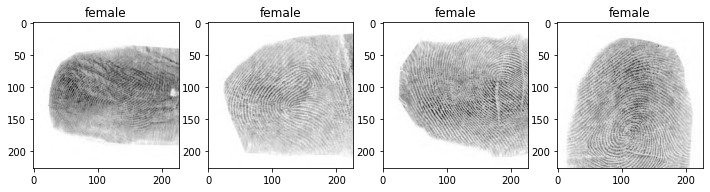

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(gender_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(gender_Alex_X_train[ind])
    plt.title(classes[0][np.argmax(gender_Alex_Y_train[ind])])

**Preprocessed Data**

In [ ]:
epochs = 500
batch_size = 128
model_path_name =  model_path +"/model_AlexNet_gender_500_weights_aug.best.hdf5"

In [ ]:
(gender_Alex_X_train, gender_Alex_Y_train) = preprocess_data(gender_Alex_X_train, gender_Alex_Y_train)
(gender_Alex_X_test, gender_Alex_Y_test) = preprocess_data(gender_Alex_X_test, gender_Alex_Y_test)

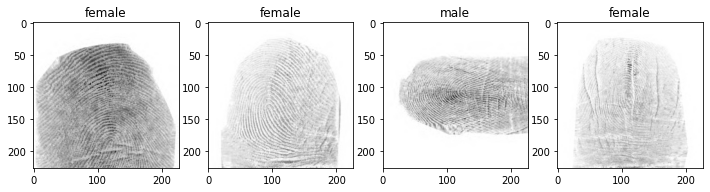

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(gender_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(gender_Alex_X_train[ind])
    plt.title(classes[0][np.argmax(gender_Alex_Y_train[ind])])

**Start Training!**

**500 epochs ve lr=0.01**

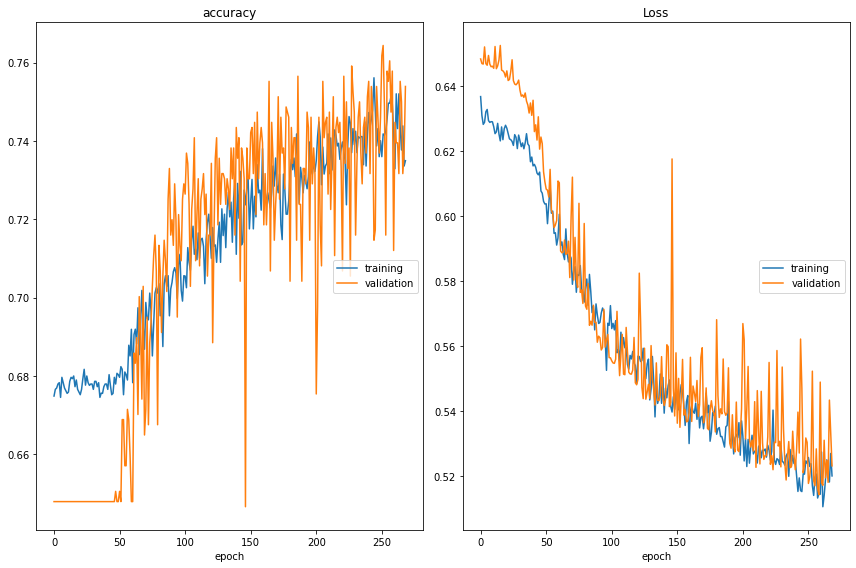

accuracy
	training         	 (min:    0.675, max:    0.756, cur:    0.735)
	validation       	 (min:    0.647, max:    0.764, cur:    0.754)
Loss
	training         	 (min:    0.511, max:    0.637, cur:    0.520)
	validation       	 (min:    0.514, max:    0.653, cur:    0.523)
23/23 [==============================] - 29s 1s/step - loss: 0.5201 - accuracy: 0.7350 - val_loss: 0.5232 - val_accuracy: 0.7539
Epoch 270/500
23/23 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7558
Epoch 270: val_loss improved from 0.51434 to 0.51428, saving model to /content/drive/MyDrive/SON_models_Finger/model_AlexNet_gender_500_weights_aug.best.hdf5


In [ ]:
%%time
train_model(Alexnet_model, 
            gender_Alex_X_train, 
            gender_Alex_Y_train, 
            gender_Alex_X_test, 
            gender_Alex_Y_test, 
            epochs, 
            batch_size, 
            model_path_name)

# age: Cnn(AlexNet) Training !: Uzun süre :( 
**AlexNet Model**

In [ ]:
INPUT_SHAPE = (227,227,3)
N_CLASSES = len(classes[1])
LR = 0.01
Alexnet_model = Alexnet(INPUT_SHAPE = INPUT_SHAPE, N_CLASSES=N_CLASSES, LR=LR)
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

**Raw Data**

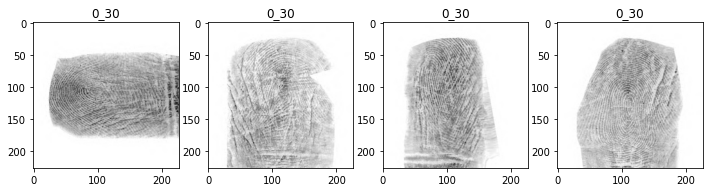

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(age_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(age_Alex_X_train[ind])
    plt.title(classes[1][np.argmax(age_Alex_Y_train[ind])])

**Preprocessed Data**

In [ ]:
epochs = 500
batch_size = 128
model_path_name =  model_path +"/model_AlexNet_age_500_weights_aug.best.hdf5"

In [ ]:
(age_Alex_X_train, age_Alex_Y_train) = preprocess_data(age_Alex_X_train, age_Alex_Y_train)
(age_Alex_X_test, age_Alex_Y_test) = preprocess_data(age_Alex_X_test, age_Alex_Y_test)

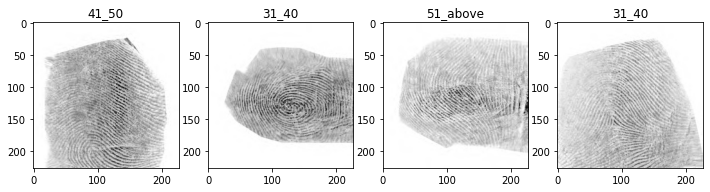

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(age_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(age_Alex_X_train[ind])
    plt.title(classes[1][np.argmax(age_Alex_Y_train[ind])])

**Start Training!**

**500 epochs ve lr=0.01**

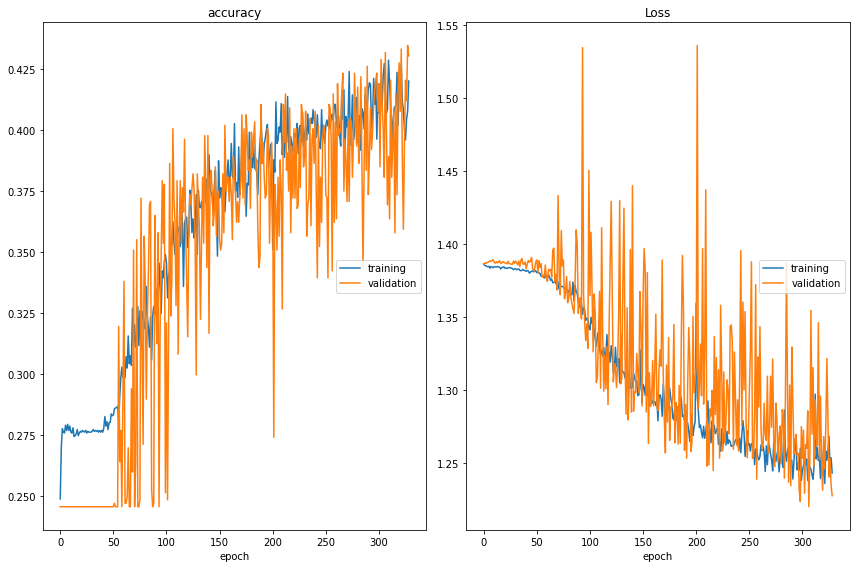

accuracy
	training         	 (min:    0.249, max:    0.429, cur:    0.420)
	validation       	 (min:    0.246, max:    0.435, cur:    0.430)
Loss
	training         	 (min:    1.236, max:    1.386, cur:    1.243)
	validation       	 (min:    1.220, max:    1.536, cur:    1.228)
22/22 [==============================] - 27s 1s/step - loss: 1.2433 - accuracy: 0.4201 - val_loss: 1.2278 - val_accuracy: 0.4304
Epoch 330/500
14/22 [==================>...........] - ETA: 9s - loss: 1.2629 - accuracy: 0.3929 

In [ ]:
%%time
train_model(Alexnet_model, 
            age_Alex_X_train, 
            age_Alex_Y_train, 
            age_Alex_X_test, 
            age_Alex_Y_test, 
            epochs, 
            batch_size, 
            model_path_name)

# race: Cnn(AlexNet) Training !: Uzun süre :( 
**AlexNet Model**

In [ ]:
INPUT_SHAPE = (227,227,3)
N_CLASSES = len(classes[2])
LR = 0.01
Alexnet_model = Alexnet(INPUT_SHAPE = INPUT_SHAPE, N_CLASSES=N_CLASSES, LR=LR)
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

**Raw Data**

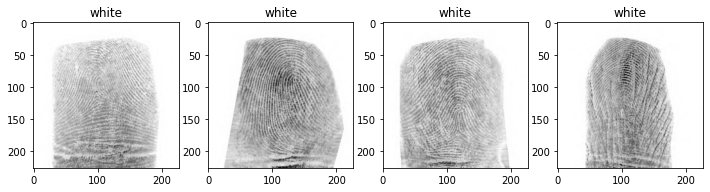

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(race_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(race_Alex_X_train[ind])
    plt.title(classes[2][np.argmax(race_Alex_Y_train[ind])])

**Preprocessed Data**

In [ ]:
epochs = 500
batch_size = 128
model_path_name =  model_path +"/model_AlexNet_race_500_weights_aug.best.hdf5"

In [ ]:
(race_Alex_X_train, race_Alex_Y_train) = preprocess_data(race_Alex_X_train, race_Alex_Y_train)
(race_Alex_X_test, race_Alex_Y_test) = preprocess_data(race_Alex_X_test, race_Alex_Y_test)

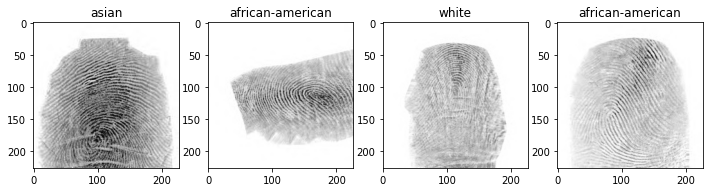

In [ ]:
plt.figure(figsize = (12,7)) 
for i in range(4):
    ind = random.randint(0, len(race_Alex_X_train))
    plt.subplot(240 + 1 + i)
    plt.imshow(race_Alex_X_train[ind])
    plt.title(classes[2][np.argmax(race_Alex_Y_train[ind])])

**Start Training!**

**500 epochs ve lr=0.01**

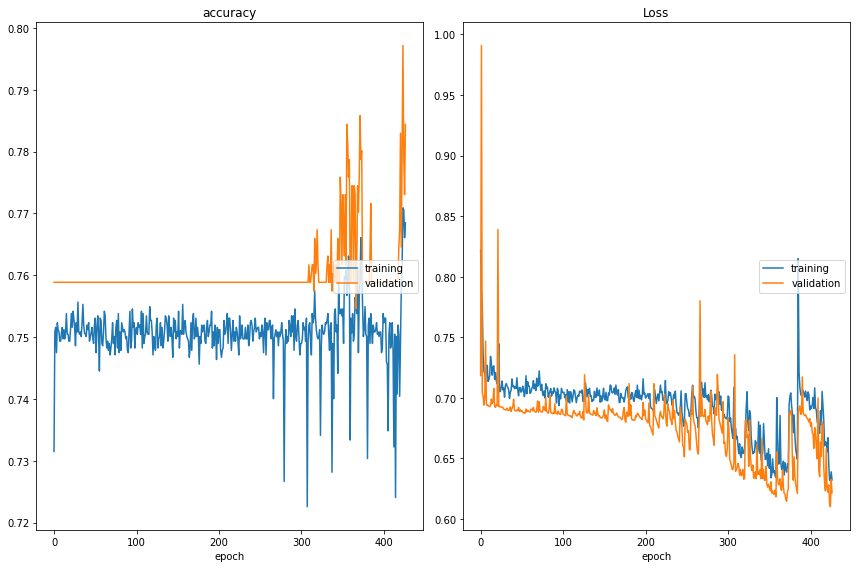

accuracy
	training         	 (min:    0.723, max:    0.771, cur:    0.768)
	validation       	 (min:    0.755, max:    0.797, cur:    0.784)
Loss
	training         	 (min:    0.631, max:    0.822, cur:    0.632)
	validation       	 (min:    0.610, max:    0.991, cur:    0.622)
22/22 [==============================] - 29s 1s/step - loss: 0.6322 - accuracy: 0.7685 - val_loss: 0.6215 - val_accuracy: 0.7844
Epoch 428/500
21/22 [===========================>..] - ETA: 1s - loss: 0.6245 - accuracy: 0.7739

In [ ]:
%%time
train_model(Alexnet_model, 
            race_Alex_X_train, 
            race_Alex_Y_train, 
            race_Alex_X_test, 
            race_Alex_Y_test, 
            epochs, 
            batch_size, 
            model_path_name)